## LG M50 Single Pulse Parameter Identification

This example presents an experimental parameter identification method for a two-RC circuit model. The data for this notebook is located within the same directory and was obtained from WDWidanage/Simscape-Battery-Library [[1]](https://github.com/WDWidanage/Simscape-Battery-Library/tree/a3842b91b3ccda006bc9be5d59c8bcbd167ceef7/Examples/parameterEstimation_TECMD/Data).


### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install PyBOP for the fitting and Pandas for the data ingestion and manipulation:

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop[plot] -q
%pip install pandas -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

With the environment set up, we can now import PyBOP alongside other libraries we will need:

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import pybamm
from scipy.io import loadmat

import pybop

## Importing Data

The data is imported as a dictionary with the following key level:
- ["LGM50_5Ah_Pulse"]
    - Temperature-> ["T0"]
        - State of Charge ->["SoC3"]
            - Cell number -> ["Cell1"]
                - Corresponding data -> ["data"]

Using SciPy's `loadmat`, we import the data from the MAT containers:

In [ ]:
ocp = loadmat("data/LGM50_5Ah_OCV.mat", simplify_cells=True, mat_dtype=False)
pulse_data = loadmat("data/LGM50_5Ah_Pulse.mat", simplify_cells=True, mat_dtype=False)
rate_data = loadmat("data/LGM50_5Ah_RateTest.mat", simplify_cells=True, mat_dtype=False)

### Convert to Dataframes

Next, we construct a dataframe from a selected pulse. In this case, we select the data for zero degrees (`T0`) with a state-of-charge of 90% (`SoC9`) and the 19th cell (`Cell19`). This can be extended to multiple pulses, or a different selection.

Additionally, we apply two filters to the dataframe to ensure the data contains only monotonically increasing time samples without duplicates.

In [ ]:
df = pd.DataFrame(pulse_data["LGM50_5Ah_Pulse"]["T0"]["SoC9"]["Cell19"]["data"])
df["ProgTime"] = df["ProgTime"] - df["ProgTime"].min()
df.drop_duplicates(subset=["ProgTime"], inplace=True)

A plot of time vs voltage confirms the data looks correct for fitting. In this situation, we would prefer to have additional samples from the relaxation, but as we will show below, PyBOP is still able to identify parameter values that fit this system.

In [ ]:
go.Figure(
    data=go.Scatter(
        x=df["ProgTime"],
        y=df["Voltage"],
    )
)

Next, we construct the OCV function from the imported `OCV` data. This is completed with a wrapper method on the `pybamm.Interpolant` function,

In [ ]:
def ocv_LGM50(sto):
    name = "OCV"
    x = (ocp["LGM50_5Ah_OCV"]["T25"]["refSoC"].reshape(-1) / 100,)
    y = ocp["LGM50_5Ah_OCV"]["T25"]["meanOCV"].reshape(-1)
    return pybamm.Interpolant(x, y, sto, name)

We can construct the two RC parameter set with initial values as listed. Note, the initial SOC is shifted slightly to better match the zero degree data.

In [ ]:
params = pybop.ParameterSet(
    params_dict={
        "chemistry": "ecm",
        "Initial SoC": 0.9 - 0.01,
        "Initial temperature [K]": 25 + 273.15,
        "Cell capacity [A.h]": 5,
        "Nominal cell capacity [A.h]": 5,
        "Ambient temperature [K]": 25 + 273.15,
        "Current function [A]": 4.85,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 3.0,
        "Cell thermal mass [J/K]": 1000,
        "Cell-jig heat transfer coefficient [W/K]": 10,
        "Jig thermal mass [J/K]": 500,
        "Jig-air heat transfer coefficient [W/K]": 10,
        "Open-circuit voltage [V]": ocv_LGM50,
        "R0 [Ohm]": 0.005,
        "Element-1 initial overpotential [V]": 0,
        "Element-2 initial overpotential [V]": 0,
        "R1 [Ohm]": 0.0001,
        "R2 [Ohm]": 0.0001,
        "C1 [F]": 3000,
        "C2 [F]": 6924,
        "Entropic change [V/K]": 0.0004,
    }
)

## Identifying the Parameters

Now that the initial parameter set is defined, we can start the PyBOP fitting process. First, we construct the model class with two RC elements and the corresponding parameter set.

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=params, options={"number of rc elements": 2}
)

In this example, we are going to try to fit all five parameters at once. To do this, we define a `pybop.Parameter` for each fitting parameter and compile them in pybop.Parameters,

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(0.005, 0.0001),
        bounds=[1e-6, 2e-1],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-6, 1],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(0.0001, 0.0001),
        bounds=[1e-6, 1],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(3000, 2500),
        bounds=[0.5, 1e4],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(3000, 2500),
        bounds=[0.5, 1e4],
    ),
)

We can now form the `pybop.Dataset` from the experimental data. In this situation, the applied current convention is different between the experimental data and PyBOP's convention. This is solved by negating the vector on construction.

In [ ]:
dataset = pybop.Dataset(
    {
        "Time [s]": df["ProgTime"].values,
        "Current function [A]": -df["Current"].values,
        "Voltage [V]": df["Voltage"].values,
    }
)

The `FittingProblem` class provides us with a class to hold all of the objects we need to evaluate our selected `SumSquaredError` cost function. 

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
cost = pybop.SumSquaredError(problem)

The cost function can be interrogated manually via the `cost([params])` API. In this example, that would look like the following,

In [ ]:
cost([0.01, 0.01, 0.01, 20000, 20000])

1.1767544040154971

Next, we construct the optimisation class with our algorithm of choice and run it. In this case, we select the PSO method as it provides global optimisation capability. After optimisation, we can compare the initial parameters to the identified parameters.

In [ ]:
optim = pybop.PSO(cost, max_unchanged_iterations=55, threshold=1e-6)
x, final_cost = optim.run()
print("Initial parameters:", optim.x0)
print("Estimated parameters:", x)

Initial parameters: [5.05414542e-03 1.35460316e-04 1.71734500e-04 2.91654402e+03
 1.46187129e+03]
Estimated parameters: [4.89715897e-02 7.07824902e-04 4.36641265e-01 7.63336402e+03
 1.28972010e+03]


## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation. The `quick_plot` method provides a fast scatter of two variables. For this example, we plot the identified parameter set to the target dataset. The default plot is voltage vs time as shown below.

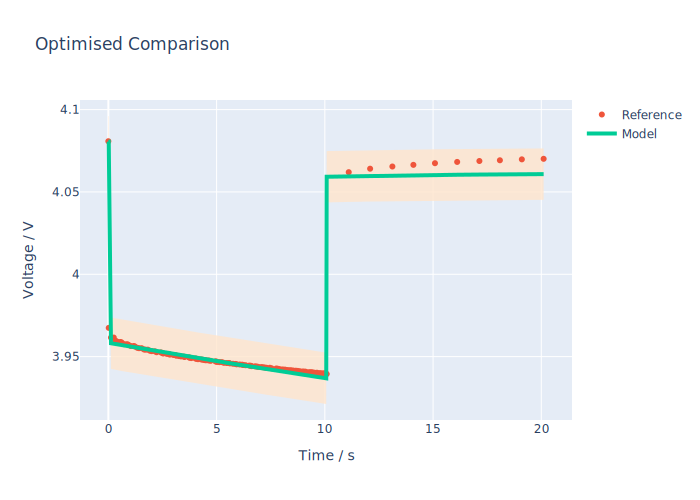

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Optimised Comparison");

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

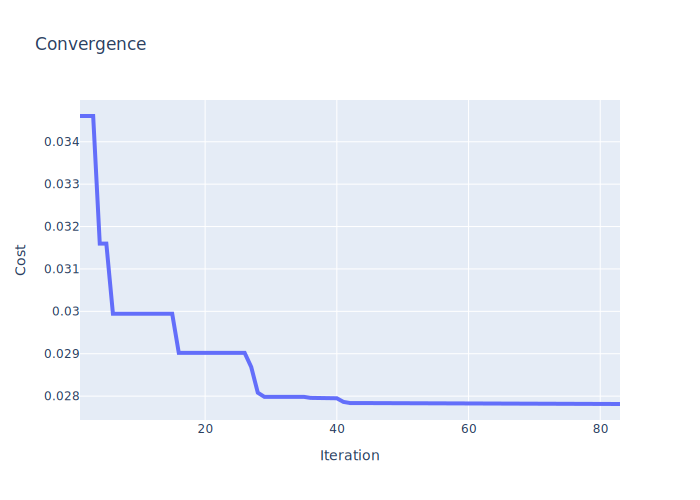

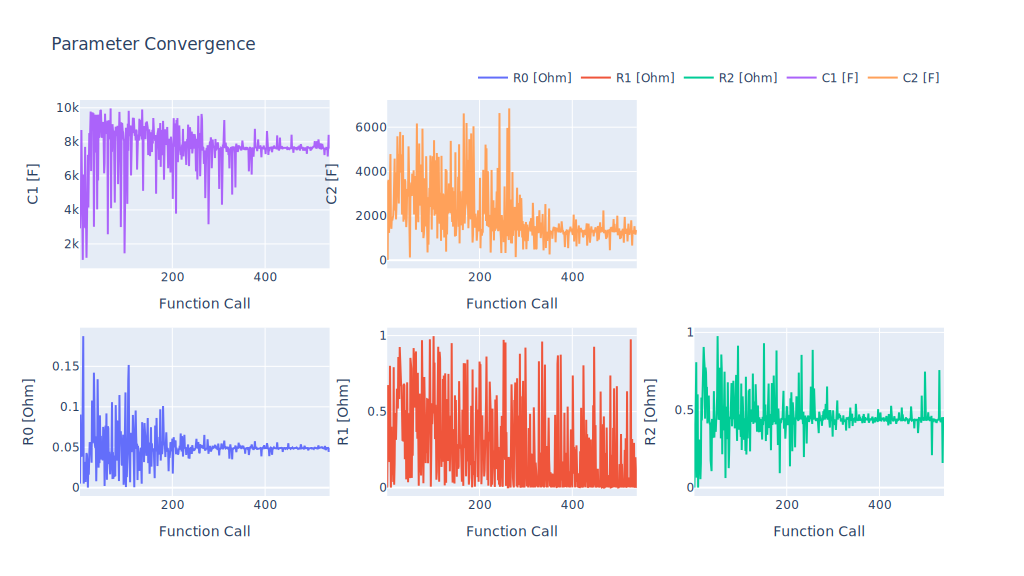

In [ ]:
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

## Validating the Fit

We've identified parameters from a single discharge pulse. Now, let's ask ourselves how well these parameters extrapolate to other operational conditions. To accomplish this, let's load a new pulse dataset at 80% SOC and compare it to our identified forward model.

In [ ]:
df_pulse_two = pd.DataFrame(
    pulse_data["LGM50_5Ah_Pulse"]["T0"]["SoC8"]["Cell19"]["data"]
)
df_pulse_two["ProgTime"] = df_pulse_two["ProgTime"] - df_pulse_two["ProgTime"].min()
df_pulse_two.drop_duplicates(subset=["ProgTime"], inplace=True)

Next, we construct a new `pybop.Dataset` from the second pulse data,

In [ ]:
dataset_two_pulse = pybop.Dataset(
    {
        "Time [s]": df_pulse_two["ProgTime"].values,
        "Current function [A]": -df_pulse_two["Current"].values,
        "Voltage [V]": df_pulse_two["Voltage"].values,
    }
)

Now that we have a new dataset, we update the target within the problem class as well as the `Initial SoC` value. Once that has been completed, we rebuild the model.

In [ ]:
problem.set_target(dataset_two_pulse)
model.parameter_set["Initial SoC"] = 0.8 - 0.0075
model.rebuild(dataset_two_pulse)

Let's plot the parameterised forward model against the new pulse data:

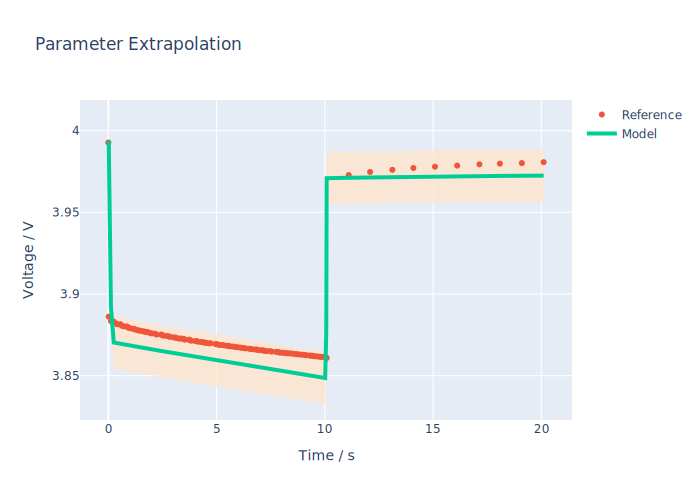

In [ ]:
pybop.quick_plot(problem, problem_inputs=x, title="Parameter Extrapolation");

As expected, when identifying parameters from a single pulse, extrapolation to different operating conditions is challenging. To solve this issue, parameter identification with various pulse datasets is recommended.

### Conclusion

This notebook illustrates how to perform circuit model parameter identification using PSO in PyBOP, providing insights into the optimisation process through various visualisations.